Proyek Tugas Akhir Mata Kuliah Data Mining

**ANALISIS SENTIMEN ULASAN GIM GENSHIN IMPACT PADA GOOGLE PLAY STORE MENGGUNAKAN NAÏVE BAYES CLASSIFIER**

---



# **Data Collection**

In [604]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [605]:
import pandas as pd

data = pd.read_excel('/content/drive/My Drive/data mining (preyok)/reviews_genshin_balanced.xlsx')
data

,review,rating
0,Game sangat bagus bahkan perta nyaan sangat lu...,5
1,"Keren dah ini game sumpah, gada bosennya maen ...",5
2,Saat saya masuk genshin impact saya menunggu s...,3
3,Tolong lah kondisikan grafik dengan spesifikas...,5
4,kenapa setiap buat akun baru gak bisa mesti tu...,2
...,...,...
1495,Karena saat saya masuk dalam geem nya tidak bi...,2
1496,Game nya seru banget cuma minus di 2 hal;Gacha...,4
1497,"overall bagus, tapi saya gamon sama ex-crush s...",5
1498,Tolong untuk download pack nya jangan besar ba...,3


# **Data Labeling**

In [606]:
import matplotlib.pyplot as plt
from sklearn.utils import resample

def label_sentiment(rating):
  if rating in [1, 2, 3]:
    return 'negatif'
  elif rating in [4, 5]:
    return 'positif'
  else:
    return None

data['sentiment'] = data['rating'].apply(label_sentiment)
df_pos = data[data['sentiment'] == 'positif']
df_neg = data[data['sentiment'] == 'negatif']


# **Visualisasi Data Tahap Awal**

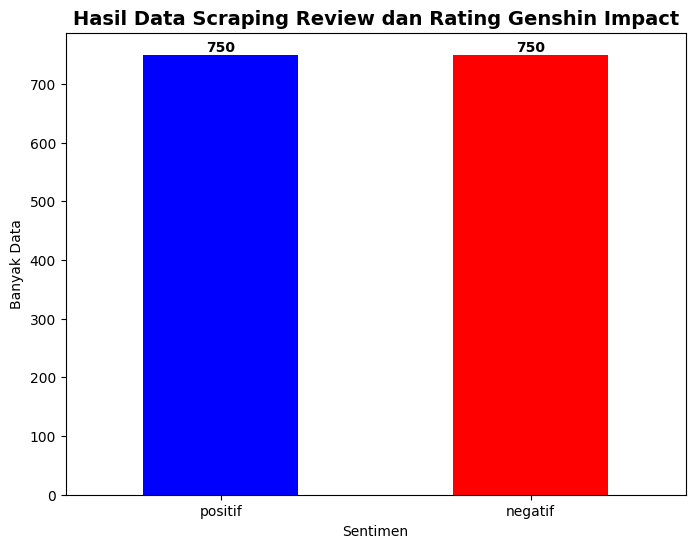

In [607]:
sentiment_counts = data['sentiment'].value_counts().reindex(['positif', 'negatif'])

colors = ['blue', 'red']

plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=colors)
plt.title('Hasil Data Scraping Review dan Rating Genshin Impact', fontsize=14, fontweight='bold')
plt.xlabel('Sentimen')
plt.ylabel('Banyak Data')
plt.xticks(rotation=0) # Keep labels horizontal
for i, value in enumerate(sentiment_counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.show()


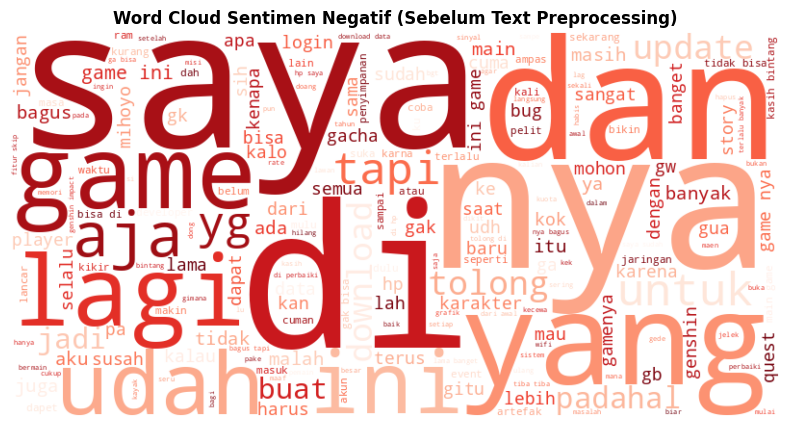

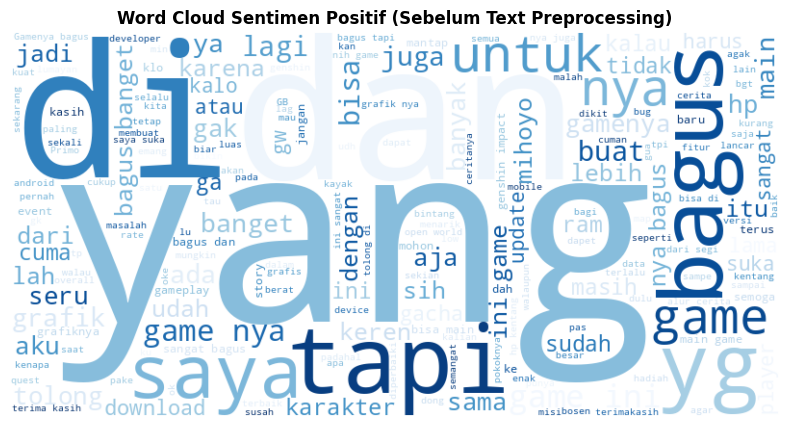

In [608]:
from wordcloud import WordCloud

for sentiment, color_palette in zip(['negatif', 'positif'], ['Reds', 'Blues']):
    text = ' '.join(data[data['sentiment'] == sentiment]['review'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color_palette).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud Sentimen {sentiment.capitalize()} (Sebelum Text Preprocessing)', fontweight="bold")
    plt.show()

# **Text Preprocessing**



---

Data Cleaning and Filtering

In [609]:
!pip install Sastrawi

In [610]:
import numpy as np
import re
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [611]:
print(data['review'].isnull().sum())
print(data['review'].duplicated().sum()
)

0
0


In [612]:
data[data['review'].duplicated(keep=False)]

,review,rating,sentiment


In [613]:
data = data.drop_duplicates(subset='review')

In [614]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
stemmer = StemmerFactory().create_stemmer()

In [615]:
#Casefolding

data['casefolded'] = data['review'].str.lower()

In [616]:
#Hapus karakter yang tidak diperlukan
def clean_text_symbols(text):
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Hapus emoji/karakter non-ASCII
    text = re.sub(r'[^a-z\s]', ' ', text)       # Hapus simbol, angka, tanda baca
    return text

def remove_repeated_chars(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)

data['no_symbols'] = data['casefolded'].apply(clean_text_symbols)
data['no_repeat'] = data['no_symbols'].apply(remove_repeated_chars)

In [617]:
def load_slang_dict(filepath):
    slang_dict = {}
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            if ":" in line:
                key, value = line.strip().split(":", 1)
                slang_dict[key.strip()] = value.strip()
    return slang_dict

file_path = "/content/drive/My Drive/data mining (preyok)/daftar_slang.txt"
all_slang = load_slang_dict(file_path)


In [618]:
def load_stopwords(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        return set(line.strip() for line in file if line.strip())

# Ganti path sesuai lokasi file kamu
stopwords_path = "/content/drive/My Drive/data mining (preyok)/custom_stopwords.txt"
custom_stopwords = load_stopwords(stopwords_path)

full_stopwords = set(stopwords).union(custom_stopwords)

In [619]:
def normalize_slang_multi(text, max_loops=3):
    words = text.split()
    for _ in range(max_loops):
        new_words = [all_slang.get(word, word) for word in words]
        if new_words == words:
            break
        words = new_words
    return ' '.join(words)

data['normalized'] = data['no_repeat'].apply(lambda x: normalize_slang_multi(x, max_loops=3))


In [620]:
def remove_stopwords(text):
    words = text.split()
    filtered = [word for word in words if word not in full_stopwords]
    return ' '.join(filtered)

data['no_stopwords'] = data['normalized'].apply(remove_stopwords)

In [621]:
data['tokenized'] = data['no_stopwords'].apply(lambda x: x.split())

In [622]:
def stem_words(words):
    joined = ' '.join(words)
    return stemmer.stem(joined)

data['stemmed'] = data['tokenized'].apply(stem_words)

In [623]:
print(data.isnull().sum())  # lihat kolom mana yang masih kosong


review          0
rating          0
sentiment       0
casefolded      0
no_symbols      0
no_repeat       0
normalized      0
no_stopwords    0
tokenized       0
stemmed         0
dtype: int64


In [624]:
from google.colab import files

output_path = 'gemis ver 2.xlsx'
data.to_excel(output_path, index=False)
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [625]:
data[['review', 'casefolded', 'no_symbols', 'no_repeat', 'normalized', 'no_stopwords', 'tokenized', 'stemmed']].sample(5, random_state=5)

,review,casefolded,no_symbols,no_repeat,normalized,no_stopwords,tokenized,stemmed
656,Game ini memberi inspirasi untuk saya. Game in...,game ini memberi inspirasi untuk saya. game in...,game ini memberi inspirasi untuk saya game in...,game ini memberi inspirasi untuk saya game in...,gim ini memberi inspirasi untuk saya gim ini s...,gim memberi inspirasi gim seru dimainkan waktu...,"[gim, memberi, inspirasi, gim, seru, dimainkan...",gim beri inspirasi gim seru main waktu luang h...
931,Sebaiknya download isinya pas udh di loby aja ...,sebaiknya download isinya pas udh di loby aja ...,sebaiknya download isinya pas udh di loby aja ...,sebaiknya download isinya pas udh di loby aja ...,sebaiknya unduh isinya pas sudah di lobi saja ...,sebaiknya unduh isinya lobi awal unduh suru un...,"[sebaiknya, unduh, isinya, lobi, awal, unduh, ...",baik unduh isi lobi awal unduh suru unduh bose...
822,Saya ada keluhan tolong bolehkan player HP ken...,saya ada keluhan tolong bolehkan player hp ken...,saya ada keluhan tolong bolehkan player hp ken...,saya ada keluhan tolong bolehkan player hp ken...,saya ada keluhan tolong bolehkan pemain handph...,keluhan bolehkan pemain handphone spesifikasi ...,"[keluhan, bolehkan, pemain, handphone, spesifi...",keluh boleh main handphone spesifikasi rendah ...
669,Kenapa gue ngak bisa main.. Tiap kali login ja...,kenapa gue ngak bisa main.. tiap kali login ja...,kenapa gue ngak bisa main tiap kali login ja...,kenapa gue ngak bisa main tiap kali login jari...,kenapa saya tidak bisa main setiap kali masuk ...,main kali masuk jaringannya eror buka jaringan...,"[main, kali, masuk, jaringannya, eror, buka, j...",main kali masuk jaring eror buka jaring bagus ...
1187,Farming artefak gak ngotak orang nyari crit bu...,farming artefak gak ngotak orang nyari crit bu...,farming artefak gak ngotak orang nyari crit bu...,farming artefak gak ngotak orang nyari crit bu...,farming artefak tidak masuk akal orang mencari...,farming artefak masuk akal mencari crit bukan ...,"[farming, artefak, masuk, akal, mencari, crit,...",farming artefak masuk akal cari crit bukan def...


In [626]:
from collections import Counter
words = ' '.join(data['stemmed']).split()
counter = Counter(words)
print(counter.most_common(50))


[('gim', 1219), ('main', 765), ('bagus', 618), ('karakter', 290), ('baru', 278), ('unduh', 258), ('handphone', 248), ('baik', 216), ('grafik', 189), ('cerita', 189), ('developer', 189), ('masuk', 167), ('lama', 164), ('genshin', 145), ('undi', 137), ('masalah', 133), ('seru', 132), ('suka', 123), ('terlalu', 116), ('rendah', 107), ('bintang', 100), ('hadiah', 94), ('spesifikasi', 93), ('kurang', 92), ('besar', 91), ('susah', 88), ('kali', 88), ('impact', 82), ('quest', 82), ('mohon', 81), ('ram', 80), ('benar', 80), ('keren', 79), ('fitur', 75), ('makin', 75), ('ulang', 72), ('mantap', 72), ('terima', 71), ('eksplorasi', 71), ('jaring', 71), ('coba', 70), ('akun', 69), ('selalu', 65), ('acara', 65), ('buruk', 63), ('uang', 62), ('awal', 62), ('sekarang', 62), ('habis', 62), ('biar', 60)]


# **Proses Pemodelan menggunakan Naive Bayes**

---
Pembagian Data Training dan Testing (80:20)

In [627]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [628]:
x = data['stemmed']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=1234)


In [629]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.7
)

x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

In [630]:

nb_model = MultinomialNB()
nb_model.fit(x_train_vec, y_train)

MultinomialNB()

In [631]:
y_pred = nb_model.predict(x_test_vec)

In [632]:
from sklearn.metrics import accuracy_score

# Prediksi untuk data training
y_train_pred = nb_model.predict(x_train_vec)


# Akurasi data training
train_accuracy = accuracy_score(y_train, y_train_pred)
print("🧪 Akurasi Data Training:", train_accuracy)
print(classification_report(y_train, y_train_pred))

# Akurasi data testing
test_accuracy = accuracy_score(y_test, y_pred)
print("🔬 Akurasi Data Testing:", test_accuracy)


🧪 Akurasi Data Training: 0.87
              precision    recall  f1-score   support

     negatif       0.88      0.87      0.87       609
     positif       0.86      0.87      0.87       591

    accuracy                           0.87      1200
   macro avg       0.87      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200

🔬 Akurasi Data Testing: 0.8033333333333333


**Evaluasi Model**

---
Evaluasi Model menggunakan Confusion Matrix

In [633]:
print("🎯 Akurasi:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

🎯 Akurasi: 0.8033333333333333

📋 Classification Report:
               precision    recall  f1-score   support

     negatif       0.79      0.79      0.79       141
     positif       0.82      0.81      0.81       159

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300



# Visualisasi Data

In [634]:
#Confusion Matrix Data TRAINING
conf_matrix_train = confusion_matrix(y_train, y_train_pred, labels=['positif', 'negatif'])

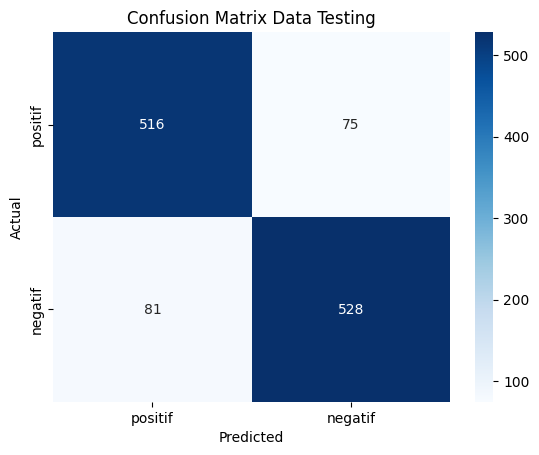

In [635]:
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['positif', 'negatif'], yticklabels=['positif', 'negatif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Testing')
plt.show()

In [636]:
#Confusion Matrix Data TESTING
conf_matrix_test = confusion_matrix(y_test, y_pred, labels=['positif', 'negatif'])

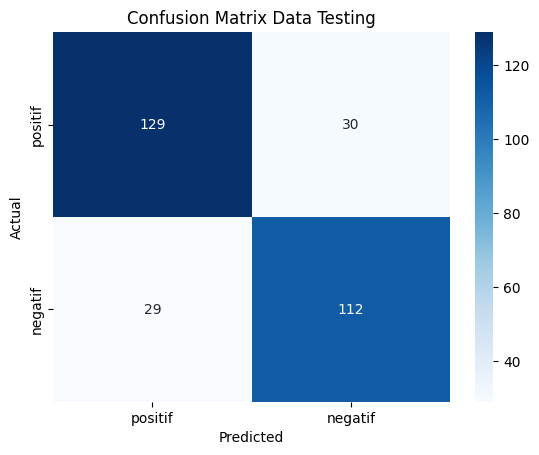

In [637]:
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['positif', 'negatif'], yticklabels=['positif', 'negatif'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Data Testing')
plt.show()

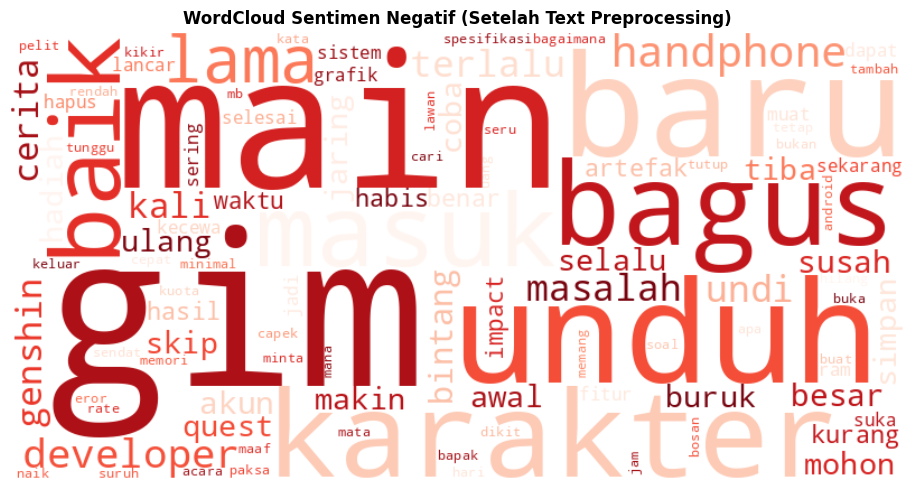

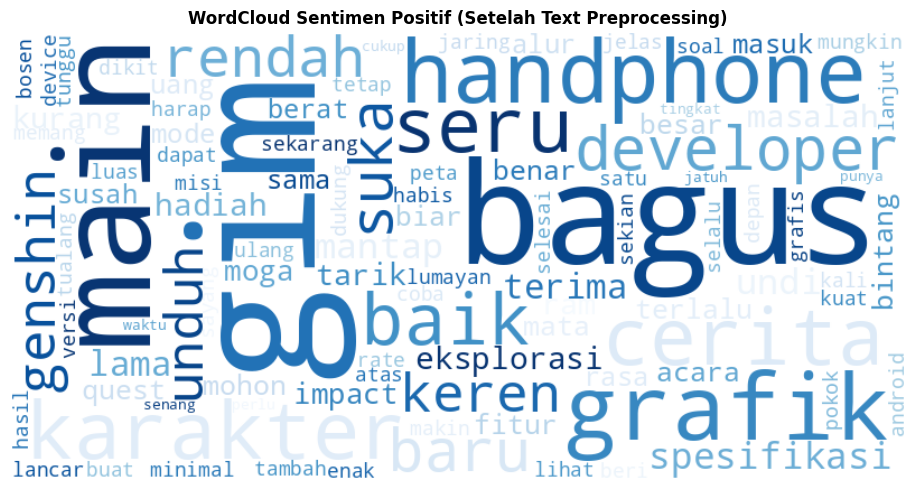

In [638]:

for sentiment, color_palette in zip(['negatif', 'positif'], ['Reds', 'Blues']):
    # Gabungkan semua kata dari kolom 'stemmed'
    all_words = ' '.join(data[data['sentiment'] == sentiment]['stemmed'].dropna()).split()
    # Hitung frekuensi per kata
    word_freq = Counter(all_words)
    # Generate wordcloud hanya dari kata (bukan frasa)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color_palette,
        max_words=100
    ).generate_from_frequencies(word_freq)
    # Tampilkan
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud Sentimen {sentiment.capitalize()} (Setelah Text Preprocessing)', fontweight="bold")
    plt.tight_layout()
    plt.show()


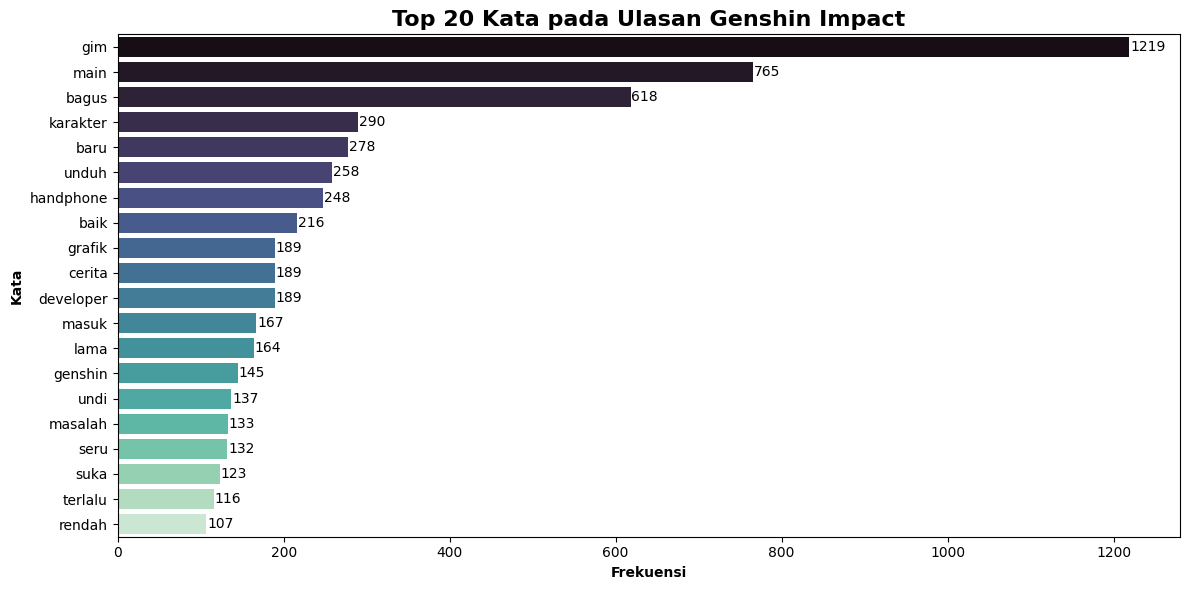

In [639]:
word_freq = Counter(words)

common_words = word_freq.most_common(20)
freq_df = pd.DataFrame(common_words, columns=['word', 'frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=freq_df, x='frequency', y='word', hue='word', dodge=False, palette='mako', legend=False)

for index, value in enumerate(freq_df['frequency']):
    plt.text(value + 1, index, str(value), va='center', fontsize=10)

plt.title('Top 20 Kata pada Ulasan Genshin Impact', fontsize=16, fontweight='bold')
plt.xlabel('Frekuensi', fontweight='bold')
plt.ylabel('Kata', fontweight='bold')
plt.tight_layout()
plt.show()


In [640]:
len(data.stemmed)

1500